# Sentimental Analysis

In [1]:
import pandas as pd
import spacy
import re

In [2]:
df = pd.read_csv(r"E:\Ex-Dowload\tweeterdata.csv",encoding='ISO-8859-1')
df.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [3]:
column_name = ['target','id','date','flag','user','text']
df = pd.read_csv(r"E:\Ex-Dowload\tweeterdata.csv",names=column_name,encoding='ISO-8859-1')
df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
df.shape

(1600000, 6)

In [5]:
df.isna().sum()

target    0
id        0
date      0
flag      0
user      0
text      0
dtype: int64

In [6]:
df['target'].value_counts()

0    800000
4    800000
Name: target, dtype: int64

In [7]:
df.replace({'target':{4:1}},inplace=True)

In [8]:
df['target'].value_counts()

0    800000
1    800000
Name: target, dtype: int64

In [9]:
from sklearn.utils import resample

def balance_and_sample(df, target_column, samples_per_class):
    # Separate the data by class
    df_class_0 = df[df[target_column] == 0]
    df_class_1 = df[df[target_column] == 1]
    
    # Sample the desired number of rows for each class
    df_class_0_sampled = resample(df_class_0, 
                                  replace=False, 
                                  n_samples=samples_per_class, 
                                  random_state=42)
    df_class_1_sampled = resample(df_class_1, 
                                  replace=False, 
                                  n_samples=samples_per_class, 
                                  random_state=42)
    
    # Combine the sampled data
    df_sampled = pd.concat([df_class_0_sampled, df_class_1_sampled])
    
    return df_sampled

# Apply the function to your dataframe
df_reduced = balance_and_sample(df, target_column='target', samples_per_class=10000)


In [10]:
df_reduced['target'].value_counts()

0    10000
1    10000
Name: target, dtype: int64

# NLP Preprocessing Steps Using Spacy

In [11]:
def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)     # Remove @mentions
    text = re.sub(r"#\w+", "", text)     # Remove hashtags
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove punctuation and numbers
    return text.lower()

In [12]:
nlp = spacy.load("en_core_web_sm")
def preprocess_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

In [13]:
df_reduced['clean_text'] = df_reduced['text'].apply(clean_text)

In [14]:
df_reduced['new_content'] = df_reduced['clean_text'].apply(preprocess_text)
df_reduced.head()

,target,id,date,flag,user,text,clean_text,new_content
212188,0,1974671194,Sat May 30 13:36:31 PDT 2009,NO_QUERY,simba98,@xnausikaax oh no! where did u order from? tha...,oh no where did u order from thats horrible,oh u order s horrible
299036,0,1997882236,Mon Jun 01 17:37:11 PDT 2009,NO_QUERY,Seve76,A great hard training weekend is over. a coup...,a great hard training weekend is over a coupl...,great hard training weekend couple day rest ...
475978,0,2177756662,Mon Jun 15 06:39:05 PDT 2009,NO_QUERY,x__claireyy__x,"Right, off to work Only 5 hours to go until I...",right off to work only hours to go until im ...,right work hour m free xd
588988,0,2216838047,Wed Jun 17 20:02:12 PDT 2009,NO_QUERY,Balasi,I am craving for japanese food,i am craving for japanese food,crave japanese food
138859,0,1880666283,Fri May 22 02:03:31 PDT 2009,NO_QUERY,djrickdawson,Jean Michel Jarre concert tomorrow gotta work...,jean michel jarre concert tomorrow gotta work...,jean michel jarre concert tomorrow get to wo...


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.8, min_df=2, max_features=10000)
X = vectorizer.fit_transform(df_reduced['new_content'])

# Train Test Split

In [16]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df_reduced['target'], test_size=0.2, random_state=0)

# Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train,y_train)

LogisticRegression()

In [18]:
y_pred = model.predict(X_test)
y_pred

array([1, 1, 1, ..., 1, 0, 1], dtype=int64)

Confusion Matrix: 
 [[1418  576]
 [ 497 1509]]
              precision    recall  f1-score   support

           0       0.74      0.71      0.73      1994
           1       0.72      0.75      0.74      2006

    accuracy                           0.73      4000
   macro avg       0.73      0.73      0.73      4000
weighted avg       0.73      0.73      0.73      4000



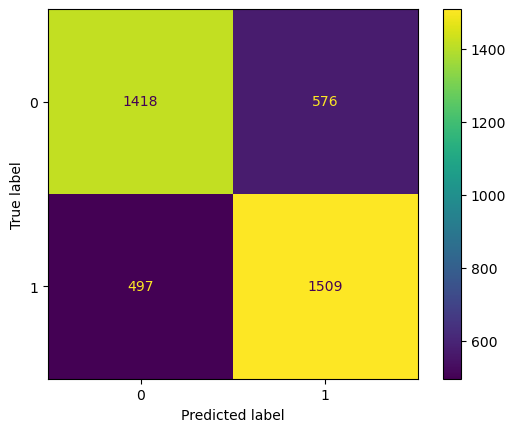

In [19]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report
cm = confusion_matrix(y_test,y_pred)
print("Confusion Matrix: \n",cm)
print(classification_report(y_test, y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot()

# Predict the new value

In [20]:
# Example input (new sentence to predict)
new_sentence = "This product is amazing, I love it!"

# Step 1: Preprocess the new input
cleaned_sentence = clean_text(new_sentence)
processed_sentence = preprocess_text(cleaned_sentence)

# Step 2: Vectorize the new input using the same vectorizer
vectorized_sentence = vectorizer.transform([processed_sentence])

# Step 3: Predict sentiment using the trained model
sentiment_prediction = model.predict(vectorized_sentence)

# Output the prediction result
print(f"Predicted Sentiment: {'Positive' if sentiment_prediction[0] == 1 else 'Negative'}")

Predicted Sentiment: Positive
